### Instalacja potrzebnych bibliotek

In [1]:
pip install keras 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install ipywidgets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.9 MB/s eta 0:00:00


### Importowanie wymaganych bibliotek

In [4]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Input 
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.models import Model 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.models import load_model 
from keras.callbacks import EarlyStopping 

import matplotlib.pyplot as plt  
import seaborn as sns  
import pandas as pd  
import numpy as np 
import math 

from IPython.display import display 
import ipywidgets as widgets 
from ipywidgets import interact 
from ipywidgets import interactive
from ipywidgets import interact_manual

from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler 


### Wczytanie bazy firmy Monari

In [33]:
data = pd.read_csv('monari.csv')

### Podzial na zbiór treningowy i testowy

In [34]:
print(data.shape) 

(2001, 6)


In [36]:
ratio = 0.8  
N = int(len(data)*ratio)  
train_df, test_df = data[:N], data[N:] 
print(train_df.shape)

(1600, 6)


In [37]:
ratio = 0.2
N = int(len(data)*ratio)
test_df, val_df = test_df[:N], test_df[N:]
print(test_df.shape)

(400, 6)


In [38]:
train_df.describe() 

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
count,1600.000000,1600.000000,1600.000000,1600.000000,1.600000e+03
mean,7.604321,7.706073,7.463012,7.590291,5.470960e+04
std,4.688539,4.741040,4.621373,4.686287,8.456938e+04
min,1.380000,1.410000,1.350000,1.370000,2.610000e+02
25%,3.040000,3.087500,2.970000,3.030000,1.335200e+04
50%,7.095000,7.200000,6.940000,7.075000,2.865750e+04
75%,10.237500,10.382500,10.002500,10.200000,6.264975e+04
max,19.255000,19.699000,19.048000,19.255000,1.052235e+06


In [39]:
rolling = data.rolling(window=7)

In [40]:
data_roll = pd.DataFrame()
data_roll['Zamkniecie']=train_df['Zamkniecie']

In [41]:
@widgets.interact_manual(lw=(1, 100))
def plot(lw):
  rolling = data.rolling(window=lw, center=True)
  data_roll = pd.DataFrame()
 
  data_roll['Zamkniecie']=data['Zamkniecie']
  data_roll['7 days rolling_mean(srednia kroczaca)']=data_roll['Zamkniecie'].rolling(lw, min_periods=1).mean()
  ax = data_roll.plot(style=['-', '--'], rot=90, figsize=(20, 10)) 
  ax.lines[0].set_alpha(0.3)  

interactive(children=(IntSlider(value=50, description='lw', min=1), Button(description='Run Interact', style=B…

### Przygotowanie danych do uczenia na sieci LSTM (zmiana wymiarow macierzy, by model zaczal obrabiac dane)

In [42]:
zmienna_przewidywana = "Zamkniecie"  

def prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio): 

  dataset = train_df[zmienna_przewidywana].values  
  dataset = dataset.astype('float32') 
  dataset = np.reshape(dataset, (-1, 1)) 
  scaler = MinMaxScaler(feature_range=(0, 1)) 
  dataset = scaler.fit_transform(dataset) 

  train_size = int(len(dataset) * ratio) 
  test_size = len(dataset) - train_size 
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:] 

  return train, test, scaler

train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8)


In [43]:
def create_dataset_lstm(dataset, look_back=1):   
    X, Y = [], [] 
    for i in range(len(dataset)-look_back-1): 
        a = dataset[i:(i+look_back), 0] 
        X.append(a) 
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y) 

look_back = 20 
X_train, Y_train = create_dataset_lstm(train, look_back) 
X_test, Y_test = create_dataset_lstm(test, look_back) 

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])) 
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1])) 

## Uczenie modelu

In [44]:
def lstm_model(X_train, Y_train, X_test, Y_test, batch_size=20): 
  model = Sequential() 
  model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2]))) 
  model.add(Dropout(0.1)) 
  model.add(Dense(8)) 
  model.compile(loss='mean_squared_error', optimizer='adam') 

  history = model.fit(X_train, Y_train, epochs=5, batch_size=10, validation_data=(X_test, Y_test), 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False) 
  return model 

## Ewaluacja modelu

In [45]:
def evaluation_model(model,X_train, X_test, Y_train, testing=False):
  dataset = train_df[zmienna_przewidywana].values
  dataset = dataset.astype('float32') 
  dataset = np.reshape(dataset, (-1, 1)) 
  scaler = MinMaxScaler(feature_range=(0, 1)) 
  dataset = scaler.fit_transform(dataset) 
  
  train_predict = model.predict(X_train) 
  test_predict = model.predict(X_test) 

  train_predict = scaler.inverse_transform(train_predict)
  Y_train = scaler.inverse_transform([Y_train])

  _mean_absolute_error = mean_absolute_error(Y_train[0], train_predict[:,0])  
  _mean_squared_error = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])) 
  print('Train Mean Absolute Error:', _mean_absolute_error) 
  print('Train Root Mean Squared Error:',_mean_squared_error)
  if testing:
    return Y_train, train_predict, _mean_absolute_error, _mean_squared_error 
  return Y_train, train_predict 

In [46]:
def a():
    return 1, 2, (10, 20)

x,y, error = a()
print(a())
print(x,y, error)

(1, 2, (10, 20))
1 2 (10, 20)


In [47]:
history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=10)

Epoch 1/5
126/126 [==============================] - 5s 20ms/step - loss: 0.1203 - val_loss: 0.0030
Epoch 2/5
126/126 [==============================] - 1s 7ms/step - loss: 0.0106 - val_loss: 0.0028
Epoch 3/5
126/126 [==============================] - 1s 6ms/step - loss: 0.0082 - val_loss: 0.0022
Epoch 4/5
126/126 [==============================] - 1s 4ms/step - loss: 0.0076 - val_loss: 0.0017
Epoch 5/5
126/126 [==============================] - 1s 4ms/step - loss: 0.0061 - val_loss: 0.0014


In [48]:
model_json = history.to_json()
with open("model.json", "w") as json_file: 
    json_file.write(model_json)
history.save_weights("model.h5")  
print("Saved model to disk")  

Saved model to disk


In [49]:
evaluation_model(history,X_train, X_test, Y_train)

10/10 [==============================] - 0s 2ms/step
Train Mean Absolute Error: 0.5964731755700233
Train Root Mean Squared Error: 0.7779235964164061


(array([[15.73500052, 15.51799967, 15.21300025, ...,  1.73000005,
          1.73499999,  1.73000005]]),
 array([[14.29175  , 13.923281 , 13.311797 , ..., 13.654763 , 13.589095 ,
         13.930693 ],
        [14.287557 , 13.935256 , 13.376933 , ..., 13.69668  , 13.594006 ,
         13.995075 ],
        [14.386644 , 13.941026 , 13.392823 , ..., 13.7435875, 13.712262 ,
         14.039455 ],
        ...,
        [ 2.3754132,  2.8014095,  2.75827  , ...,  2.6689699,  2.4432595,
          2.6941094],
        [ 2.3279767,  2.8096356,  2.7973602, ...,  2.674914 ,  2.4327645,
          2.6847908],
        [ 2.3287058,  2.8145514,  2.8013046, ...,  2.6666384,  2.4480407,
          2.6707175]], dtype=float32))

In [50]:
Y_train, train_predict = evaluation_model(history,X_train, X_test, Y_train)

10/10 [==============================] - 0s 2ms/step
Train Mean Absolute Error: 0.5964731755700233
Train Root Mean Squared Error: 0.7779235964164061


In [51]:
def visualization(Y_train, train_predict):
  N = len(Y_train[0]) 
  aa=[x for x in range(N)]
  plt.figure(figsize=(8,4))
  plt.plot(aa, Y_train[0], marker='.', label="actual") 
  plt.plot(aa, train_predict[:,0], 'r', label="prediction")
  plt.tight_layout()  
  sns.despine(top=True) 
  plt.subplots_adjust(left=0.07)  
  plt.title(" prediction")
  plt.xlabel('Time step', size=15) 
  plt.legend(fontsize=15) 
  plt.show();  

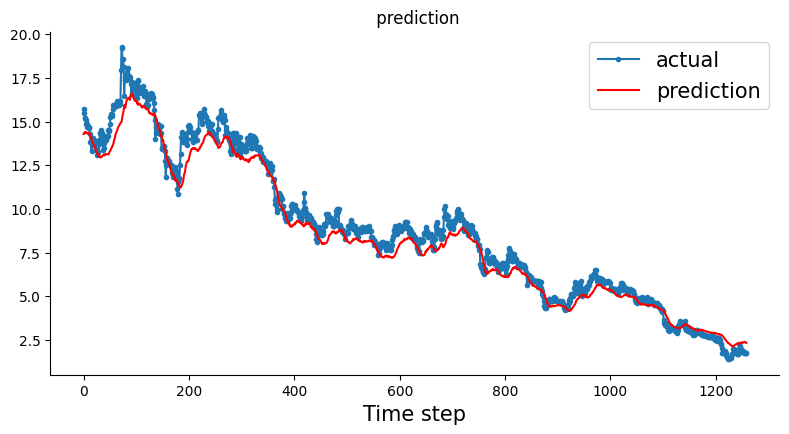

In [52]:
visualization(Y_train, train_predict)

## Zmieniamy wielkosc batch, by zobaczyc jaki wplyw ma ta zmienna na wyniki

In [53]:
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8)

def create_dataset_lstm(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 3 
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)
print(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

[[0.02180598 0.01984903 0.02460162]
 [0.01984903 0.02460162 0.03913894]
 [0.02460162 0.03913894 0.0301929 ]
 [0.03913894 0.0301929  0.03131115]
 [0.0301929  0.03131115 0.03690243]
 [0.03131115 0.03690243 0.03410679]
 [0.03690243 0.03410679 0.04193458]
 [0.03410679 0.04193458 0.04081632]
 [0.04193458 0.04081632 0.05759016]
 [0.04081632 0.05759016 0.05703104]
 [0.05759016 0.05703104 0.0503215 ]
 [0.05703104 0.0503215  0.04920324]
 [0.0503215  0.04920324 0.04696673]
 [0.04920324 0.04696673 0.03690243]
 [0.04696673 0.03690243 0.04081632]
 [0.03690243 0.04081632 0.04193458]
 [0.04081632 0.04193458 0.04584848]
 [0.04193458 0.04584848 0.04193458]
 [0.04584848 0.04193458 0.04137545]
 [0.04193458 0.04137545 0.04081632]
 [0.04137545 0.04081632 0.04193458]
 [0.04081632 0.04193458 0.04249372]
 [0.04193458 0.04249372 0.04249372]
 [0.04249372 0.04249372 0.04640761]
 [0.04249372 0.04640761 0.04249372]
 [0.04640761 0.04249372 0.04137545]
 [0.04249372 0.04137545 0.04081632]
 [0.04137545 0.04081632 0.04

In [54]:
batch_start, batch_end = 30, 40
look_backs = [3,10,30] 


error_look_back = {}
for look_back in look_backs:
  MAEs = []
  MSEs = []
  Y_trains = []
  train_predicts = []

  X_train, Y_train = create_dataset_lstm(train, look_back)
  X_test, Y_test = create_dataset_lstm(test, look_back)
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
  for batch in range(batch_start, batch_end):
    print(f'-------------------------------{batch}--------------------------')
    history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=batch)
    tmp_Y_train, tmp_train_predict, MAE, MSE  = evaluation_model(history,X_train, X_test, Y_train, testing=True)
    
    MAEs.append(MAE)
    MSEs.append(MSE)
    Y_trains.append(tmp_Y_train)
    train_predicts.append(tmp_train_predict)
  error_look_back[look_back] = {"MAE":MAEs, "MSE":MSEs, "Y_trains": Y_trains, "train_predicts": train_predicts}



-------------------------------30--------------------------
Epoch 1/5
128/128 [==============================] - 3s 8ms/step - loss: 0.1755 - val_loss: 0.0080
Epoch 2/5
128/128 [==============================] - 0s 4ms/step - loss: 0.0527 - val_loss: 0.0211
Epoch 3/5
128/128 [==============================] - 1s 4ms/step - loss: 0.0168 - val_loss: 0.0147
Epoch 4/5
128/128 [==============================] - 1s 5ms/step - loss: 0.0108 - val_loss: 0.0091
Epoch 5/5
10/10 [==============================] - 0s 3ms/step
Train Mean Absolute Error: 1.2350777398238335
Train Root Mean Squared Error: 1.5415274813643567
-------------------------------31--------------------------
Epoch 1/5
128/128 [==============================] - 3s 8ms/step - loss: 0.1858 - val_loss: 0.0055
Epoch 2/5
128/128 [==============================] - 0s 4ms/step - loss: 0.0642 - val_loss: 0.0207
Epoch 3/5
128/128 [==============================] - 0s 4ms/step - loss: 0.0173 - val_loss: 0.0166
Epoch 4/5
128/128 [=========

#### Wraz ze wzrostem batch'a, pogorszaja sie na wyniki - MAE i MSE idealnie powinny rownac sie zero, wiec generalnie im mniejsze ich wartosci, tym model uwazamy za lepszy

In [55]:
train_predict.shape

(1259, 8)

In [56]:
error_look_back[3]["MSE"]

[1.5415274813643567,
 1.5168716247114293,
 1.1066744782601317,
 1.1199749824929655,
 1.4916286876329192,
 1.6656512379648978,
 1.087542593008921,
 1.153516666587452,
 1.1166178552872013,
 1.8612757658972838]

In [57]:
MSEs.sort()
print(MSEs)

[0.7950961860658564, 0.8263654780314479, 1.0207827319862, 1.0584211629439095, 1.186720033004345, 1.1939729834706463, 1.2553851618479217, 1.2768144034107307, 1.3276126313296852, 1.4445714440207116]


<Axes: >

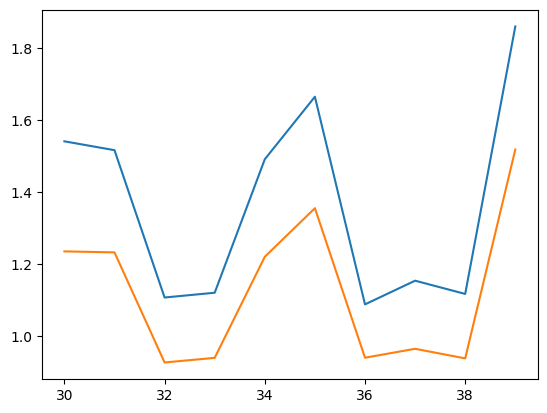

In [58]:
look_back_to_check = 3
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MSE"])
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MAE"])

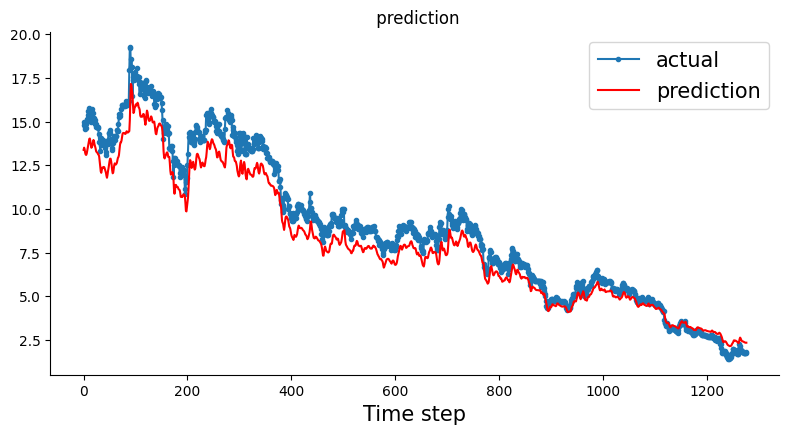

In [59]:
batch_index = 6 
look_back_to_check = 3
visualization(Y_train = error_look_back[look_back_to_check]["Y_trains"][batch_index], train_predict = error_look_back[look_back_to_check]["train_predicts"][batch_index])

In [60]:
error_look_back[3]["Y_trains"][0]

array([[14.98600004, 14.78900002, 14.57200023, ...,  1.73499999,
         1.73000005,  1.78      ]])